# AI Lab Run Reconstruction

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm

In [21]:
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import SimplerPhxLearnerInit as TheLearner
from model_dataset import WordDatasetPath as ThisDataset
from model_dataset import Normalizer, DeNormalizer
from model_dataset import MelSpecTransformNoDB as TheTransform
from model_dataset import DS_Tools
from reshandler import ReconResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut

## Preps

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Prepare for loading Model

In [5]:
ts = "0129130409"
stop_epoch = "79"
train_name = "A_01"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
assert PU.path_exist(model_save_dir)
print(f"{train_name}-{ts}")

A_01-0129130409


## Load Dataset

In [6]:
TEST = False

In [7]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       transform=mytrans)

valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


# Load Test set
if TEST: 
    test_ds = ThisDataset(rec_dir, 
                        test_guide_path, 
                        transform=mytrans)
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))

    use_test_ds = torch.utils.data.Subset(test_ds, test_ds_indices)

    test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    test_num = len(test_loader.dataset)

## Model

### Model-related defs

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [9]:
model_name = "{}.pt".format(stop_epoch)
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

SimplerPhxLearnerInit(
  (encoder): RLEncoder(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=8, bias=True)
      (relu): ReLU()
    )
  )
  (decoder): InitRALDecoder(
    (rnn): LSTM(64, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=8, out_features=64, bias=True)
      (relu): ReLU()
    )
  )
)

## Inference

In [12]:
def infer(): 
    model.eval()
    reshandler = ReconResHandler(whole_res_dir=model_save_dir, 
                                 file_prefix="recon")
    all_res = []
    all_ori = []
    all_name = []

    total = len(valid_loader)

    for (x, x_lens, name) in tqdm(valid_loader): 
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        recon_x, attn_weight = model(x, x_lens, x_mask)

        recon_x = recon_x.cpu().detach().numpy().squeeze()
        ori_x = x.cpu().detach().numpy().squeeze()

        all_res += [recon_x]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_ori += [ori_x]
        all_name += [name]
    

    reshandler.res = all_res
    reshandler.tok = all_ori
    reshandler.name = all_name
    reshandler.save()

In [13]:
if __name__ == "__main__": 
    infer()

100%|██████████| 10398/10398 [01:37<00:00, 106.14it/s]


# Load Res

In [14]:
reshandler = ReconResHandler(whole_res_dir=model_save_dir, file_prefix="recon")
reshandler.read()

# Plot some recon and original comparisons

In [15]:
# all
all_recon = reshandler.res
all_ori = reshandler.tok
all_name = reshandler.name

In [16]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [40]:
i = random.randint(0, len(all_name))

In [41]:
reshandler.name[i]

'8630-305213-0051-0005'

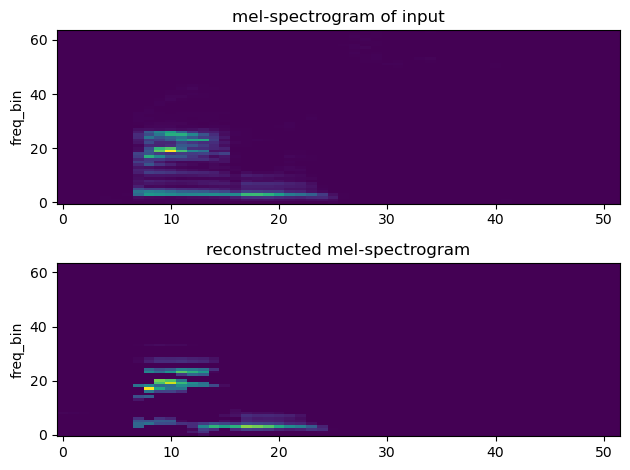

In [42]:
fig, axs = plt.subplots(2, 1)
plot_spectrogram(all_ori[i].T, title="mel-spectrogram of input", ax=axs[0])
plot_spectrogram(all_recon[i].T, title="reconstructed mel-spectrogram", ax=axs[1])
fig.tight_layout()

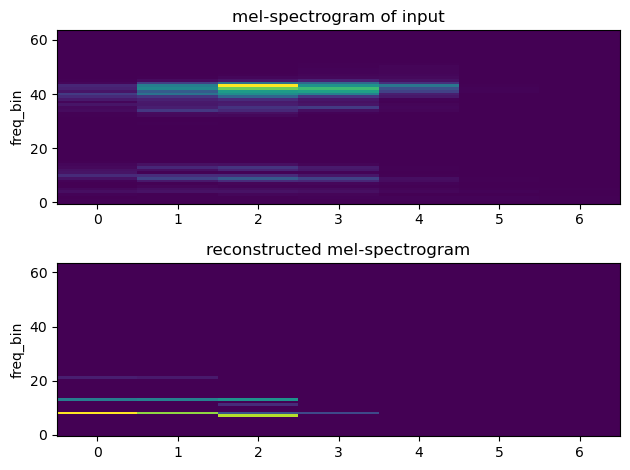

In [34]:
rec, rate = torchaudio.load(os.path.join(rec_dir, "/".join(AudioCut.solve_name(all_name[i])[:-1]), all_name[i] + ".flac"))

fig, axs = plt.subplots(2, 1)
plot_spectrogram(mytrans.de_norm(torch.from_numpy(all_ori[i]), rec).numpy().T, title="mel-spectrogram of input", ax=axs[0])
plot_spectrogram(mytrans.de_norm(torch.from_numpy(all_recon[i]), rec).numpy().T, title="reconstructed mel-spectrogram", ax=axs[1])
fig.tight_layout()

In [35]:
Audio(rec.numpy(), rate=rate)

In [36]:
Audio(mytrans.inverse(mytrans.de_norm(torch.from_numpy(all_ori[i]), rec)).numpy(), rate=REC_SAMPLE_RATE)

_LinAlgError: torch.linalg.lstsq: The least squares solution could not be computed because the input matrix does not have full rank (error code: 3).

In [29]:
Audio(mytrans.inverse(mytrans.de_norm(torch.from_numpy(all_recon[i]), rec)).numpy(), rate=REC_SAMPLE_RATE)

_LinAlgError: torch.linalg.lstsq: The least squares solution could not be computed because the input matrix does not have full rank (error code: 3).

In [30]:
Audio(mytrans.inverse(torch.from_numpy(all_ori[i])).numpy(), rate=REC_SAMPLE_RATE)

_LinAlgError: torch.linalg.lstsq: The least squares solution could not be computed because the input matrix does not have full rank (error code: 3).

In [58]:
Audio(mytrans.inverse(torch.from_numpy(all_recon[i])).numpy(), rate=REC_SAMPLE_RATE)